In [2]:
pip install pyserial

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Data added: {'timestamp': 1723392783.730098, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392784.53398, 'x': -0.31, 'y': -0.73, 'z': -0.43}
Data added: {'timestamp': 1723392784.817292, 'x': -0.31, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392785.1261508, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392785.365658, 'x': -0.31, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392785.6089332, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392785.844888, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392786.082807, 'x': -0.31, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392786.338113, 'x': -0.37, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392786.57636, 'x': -0.37, 'y': -0.79, 'z': -0.37}
Data added: {'timestamp': 1723392786.8165739, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 1723392787.0563672, 'x': -0.24, 'y': -0.79, 'z': -0.43}
Data added: {'timestamp': 

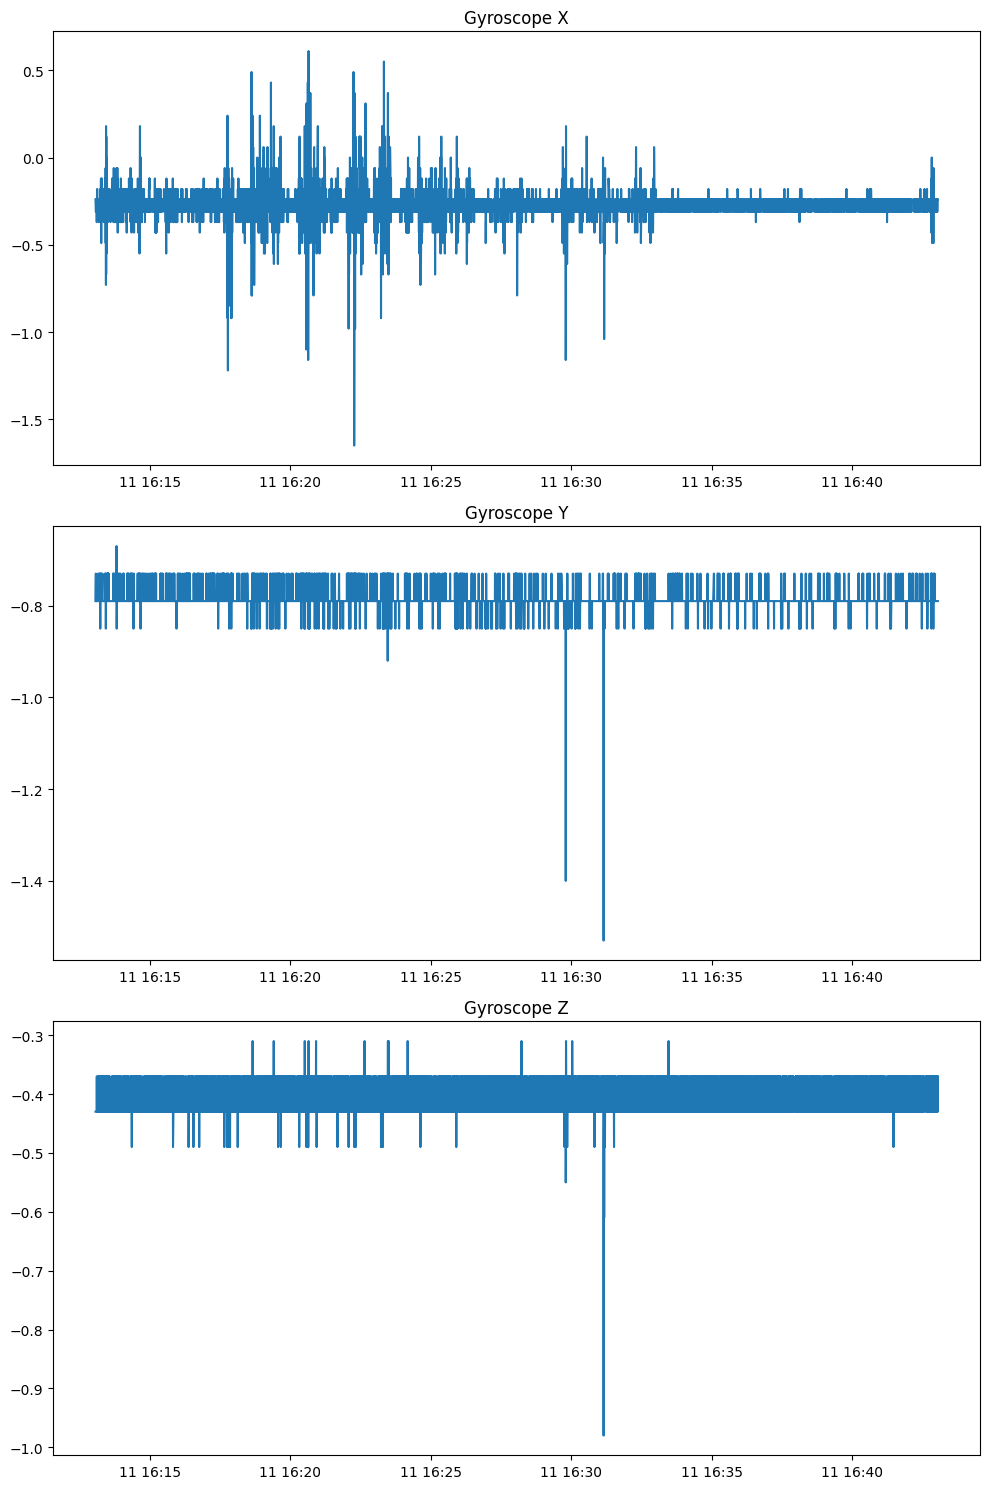

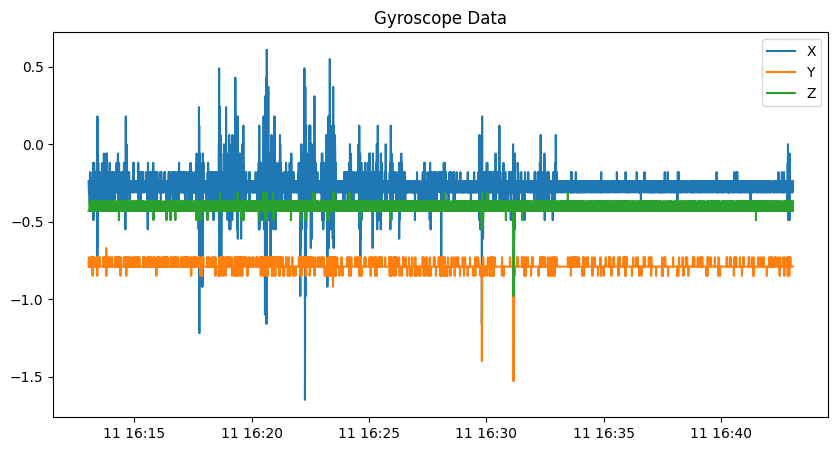

In [7]:
import serial
import time
import json
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import matplotlib.pyplot as plt

def initialize_firebase():
    try:
        default_app = firebase_admin.get_app()
    except ValueError:
        cred = credentials.Certificate("data-83b30-firebase-adminsdk-bagyf-e99b2a2ee3.json")
        default_app = firebase_admin.initialize_app(cred, {
            'databaseURL': 'https://data-83b30-default-rtdb.firebaseio.com/'
        })
    return default_app

def collect_data(duration_minutes=30):
    ref = db.reference('gyroscope_data')
    
    start_time = time.time()
    duration = duration_minutes * 60  # Convert minutes to seconds
    
    while time.time() - start_time < duration:
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').rstrip()
            try:
                x, y, z = map(float, line.split(','))
                
                data = {
                    'timestamp': time.time(),
                    'x': x,
                    'y': y,
                    'z': z
                }
                
                ref.push(data)
                print(f"Data added: {data}")
            except ValueError:
                print(f"Invalid data received: {line}")
    
    print("Data collection complete")

def analyze_data():
    ref = db.reference('gyroscope_data')
    data = ref.get()
    
    if not data:
        print("No data found in the database.")
        return
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
    # Save to CSV
    df.to_csv('gyroscope_data.csv')
    print("Data saved to gyroscope_data.csv")
    
    # Plot individual variables
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    ax1.plot(df.index, df['x'])
    ax1.set_title('Gyroscope X')
    ax2.plot(df.index, df['y'])
    ax2.set_title('Gyroscope Y')
    ax3.plot(df.index, df['z'])
    ax3.set_title('Gyroscope Z')
    plt.tight_layout()
    plt.savefig('gyroscope_individual.png')
    print("Individual plots saved to gyroscope_individual.png")
    
    # Plot combined variables
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['x'], label='X')
    plt.plot(df.index, df['y'], label='Y')
    plt.plot(df.index, df['z'], label='Z')
    plt.legend()
    plt.title('Gyroscope Data')
    plt.savefig('gyroscope_combined.png')
    print("Combined plot saved to gyroscope_combined.png")
    
    print("Analysis complete. Check the CSV file and plots.")

if __name__ == "__main__":
    # Initialize Firebase
    app = initialize_firebase()
    
    # Set up serial connection
    ser = serial.Serial('/dev/cu.usbmodem1201', 9600)  # Adjust COM port as needed
    
    try:
        # Collect data
        collect_data(duration_minutes=30)  # Adjust duration as needed
        
        # Analyze data
        analyze_data()
    except KeyboardInterrupt:
        print("Data collection interrupted by user.")
    finally:
        ser.close()
        print("Serial connection closed.")